# E-commerce — Анализ товарного ассортимента

Интернет-магазин товаров для дома «Пока все ещё тут».

Необходимо проанализировать ассортимент товаров для принятия решений по дальнейшему развитию продаваемых позиций.

Описание данных:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

# Импорт библиотек и данных

In [45]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
import datetime as dt  
import scipy.stats as stats
from scipy import stats as st                     

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv('/datasets/ecommerce_dataset.csv')

In [3]:
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


Данные и библеотеки выгружены, вижу что нужно поработать с датами и проверить на пропуски и аномалии

# Предобработка данных 

Гляну на вид данных в датасете

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


пропусков нет, все данные необходимых форматов кроме дат, данный столбец  приведу к более понятному виду, использовать буду функцию to_datetime

In [5]:
df['date'] = pd.to_datetime(df['date'].astype(str), format = '%Y%m%d%H')
df.head(10)

,date,customer_id,order_id,product,quantity,price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


Изменил данные, помимо даты у нас еще есть час покупки в данных

Гляну на наличие дубликатов в данных

In [6]:
df.duplicated().value_counts()

False    6737
dtype: int64

построчных дубликатов нет, проверю еще дубликаты без даты

In [7]:
not_data = df[df.duplicated(subset = ['customer_id', 'order_id', 'product', 'price'])]
not_data

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


очень интересно, неожидано нахожу дибликаты в датасете, 1884 шт! возможно ошибка выгруза данных, или наоборот ошибка занесения данных, решаю избавится от дубликатов

In [8]:
df = df.drop_duplicates(subset = ['customer_id','order_id', 'product','price'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4853 entries, 0 to 6735
Data columns (total 6 columns):
date           4853 non-null datetime64[ns]
customer_id    4853 non-null object
order_id       4853 non-null int64
product        4853 non-null object
quantity       4853 non-null int64
price          4853 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 265.4+ KB


от дубликатов избавился, теперь решаю добавить в датасет столбецы с видами товаров и месяцом покупки, начту с добавления групп товаров, начну с выделения первого предложения но перед этим приведу названия продуктов к нижнему регистру

In [9]:
df['product'] = df['product'].str.lower()
name_product = df['product'].apply(lambda x: x.split(",")[0])
name_product.head()

0       комнатное растение в горшке алое вера
1    комнатное растение в горшке кофе арабика
2                 радермахера d-12 см h-20 см
3            хризолидокарпус лутесценс d-9 см
4              циперус зумула d-12 см h-25 см
Name: product, dtype: object

Теперь используя лемматизацию и цикл выделю ключевые слова, предворительно пропишу стоп слова, что бы мусора было меньше

In [10]:
m = Mystem()
stop_words = [', ','\n', ' ', 'h', '1', '2', '3', '4','5','6', '7', '8', '9', '-', 'n', 'л', 'м', 'см',',', '.']
result = []
for lemma in name_product.unique():
    lemmas = m.lemmatize(lemma)
    lemmas = list(filter(lambda x : x not in stop_words, lemmas))
    result += lemmas

result

['комнатный',
 'растение',
 'в',
 'горшок',
 'алый',
 'вера',
 'комнатный',
 'растение',
 'в',
 'горшок',
 'кофе',
 'арабика',
 'радермахер',
 'd',
 '12',
 '20',
 'хризолидокарпус',
 'лутесценс',
 'd',
 'циперус',
 'зумул',
 'd',
 '12',
 '25',
 'шеффлер',
 'лузеан',
 'd',
 'юкка',
 'нитчатый',
 'd',
 '12',
 '25',
 '35',
 'настенный',
 'сушилка',
 'для',
 'белье',
 'gimi',
 'brio',
 'super',
 '100',
 'таз',
 'пластмассовый',
 '21',
 'чехол',
 'для',
 'гладильный',
 'доска',
 'colombo',
 'persia',
 'beige',
 '130х50',
 'из',
 'хлопок',
 '5379',
 'вешалка',
 'для',
 'брюки',
 'металлический',
 'с',
 'резиновый',
 'покрытие',
 '26',
 'цвет',
 ': ',
 'синий',
 'сушилка',
 'для',
 'белье',
 'потолочный',
 'zalger',
 'lift',
 'basic',
 '1520',
 '200',
 'чехол',
 'eurogold',
 'clean',
 'basic',
 'хлопок',
 'для',
 'доска',
 '120х38',
 '120х42',
 'c42',
 'крючок',
 'одежный',
 'х',
 'рожковый',
 'серый',
 'металлик',
 'с',
 'полимерный',
 'покрытие',
 ' *',
 'тонар',
 '*\n',
 'корзина',
 'мягки

За счет библиотеки collection выделю сколько раз повторяется каждое слово в наших леммах, та будет легче выписать нужные мне слова:

In [11]:
print(Counter(result))

Counter({'для': 523, 'в': 262, 'd': 255, 'с': 225, 'рассада': 221, 'сорт': 171, 'шт': 161, 'белый': 148, 'белье': 136, '12': 131, ' (': 131, 'кассета': 131, 'доска': 129, 'красный': 128, '0': 118, ') ': 115, 'объем': 114, 'цветок': 114, 'гладильный': 113, 'сушилка': 112, 'горшок': 103, 'тележка': 100, 'томат': 100, 'помидор': 93, 'сумка': 91, '10': 88, '№': 88, '. ': 84, 'диам': 80, 'из': 76, 'среднеспелый': 73, 'розовый': 72, 'кухня': 71, 'gimi': 70, 'хозяйственный': 69, 'зелень': 68, 'коврик': 68, 'и': 67, 'роза': 67, 'пеларгония': 66, 'ванный': 66, '20': 65, 'муляж': 63, 'мл': 63, '/': 61, 'искусственный': 61, 'по': 61, 'чехол': 60, 'luminarc': 60, 'ника': 59, 'черный': 58, 'однолетний': 57, 'махровый': 56, 'пластиковый': 54, 'штука': 54, 'синий': 53, 'комната': 52, 'на': 50, 'индетерминантный': 50, 'набор': 49, 'вешалка': 48, 'ручка': 47, 'петуния': 47, 'пластмассовый': 44, 'штора': 44, 'раннеспелый': 44, 'оранжевый': 43, 'зональный': 42, '100': 41, 'attribute': 41, 'капуста': 41, 

Теперь в ручную раскидаю лемы по категориям, выделю 8 категорий

In [12]:
household = ['тряпкодержатель','york','доска','блок','ролик','держатель','насадка','штанга','тряпка','рукав','ведро','набор','табурет','дозатор','мешок','пепельница','вантуз','ковш','термометр','санки','лоток','подголовник','веник','скребок','совок','урна','петля','перчатка','ванна','сметка','подставка','сушилка','ерш','таз','салфетка','швабра','банка','щетка','доска']
plants = ['лаватер','гайлардий','хамедорея','вероника', 'хамедорей','гайлардия','валериана','лантан',' блан','хамедорея','лен','гайлардия','рудбекия','кампануть','бадан','физостегия','бузульник','камнеломка','солидаго','осина','лук','гайлардия','барвинок','драцена','вербейник','джункус','хоста','цитрофортунелла','муррайя','баклажан','пиретрум','энотера','платикодон','папоротник','энотера','смолевка','красавица','пеперомия','котовник','георгина','ранункулус','эхинацея','ясколка','аврора','эпипремнум','нефролепис','калла','горох','змееголовник','гимнокалициум','любисток','дендробиум','гипсофила','шалфей','ваза','хамедорея','вигна','гардения','сельдерей','алоэ','фиттония','импатиенс','полянка','замиокулькас','скелетон','огурец','соланум','амариллис','крассула','укроп','чабер','калоцефалус','двухцветная','бальзамин','кампанул','розмарин','пахира','афеляндра','сантолина','молодило','кампанула','молодило','нолина','кампанула','лавр','литопс','мединилла','адиантум','ампанула''кодонант','плющ','фикус','алоэ''рубелла','скиммия','джулия','скиммия','сельма','фоторамка','лавсон''кипарисовик','кашим','пуансетия','подсолнечник','эшшольция','друммонд','годеция','мунлайт','капсикум','герлс','аморить','аксинья','артемизия','полынь','спиралиса','манго','орегано','нарцисс','тобаго','мелисса','иссоп','биколор','суккулент','зелень','чабрец','юкка','лузеан','зумул','циперус','лутесценс','хризолидокарпус','радермахер','салат','зверобой','клен','сакура','монард','фатсия','кольраби','сальвия','целозия','портулак','тагетис','сильвердроп','циния','анемон','попсокс','газание','свита','седум','аквилегия','лилейник','грузонь','эхинокактус','трава','эмпилабль','рондо','аптение','ель','диффенбахий','василиса','цинерария','лапчатка','кореопсис','мимоза','гарден','акаулис','виктория','морковь','ананас','чеснок','сальса','лувр','кордан','душица','аспарагус','кориандр','мирт','кофр','глоксиния','хлорофитум','калатея','композиция','герань','черешня','банан','фаленопсис','шеффлер','кабачок','астра','колокольчик','земляника','кофе','спатифиллум','флокс','пламень','календула','настурция','воларэ','патио','каландив','каланхое','лаванда','крокус','тюльпан','ромашка','овощ','тимьян','хризантема','перец','пуансеттия','лобелия','патиссон','андрианум','петрушка','комплект','примула','лимон', 'эвкалипт','азалия', 'гортензия', 'тыква','гербера','алиссум','табак','виола','бакоп','цинния','гранат','эхеверие','персик','вишня','мандарин','груша','арбуз','базилик','косметь','мята','фиалка','антуриум','цикламен','диам','клубника','яблоко','кашпо','горшок','муляж', 'цветок','бегония','виноград','дыня','фуксия','вербена','калибрахоа','капуста','растение','роза','пеларгония','петуния','помидор','томат','рассада'] 
dishes = ['сотейник','тортница','овсянница','скалка','емкость','блюдце','салфетница','терка','лопатка','блюдо','пакет','половник','овощеварка','сахарница','просеиватель','tepмокружка','орехоколка','просеиватель''пароварка','бульонница','мясорубка','картофелемялка','овощечистка','масленка','ножеточка','противень','соковарка','термос','термостакан','бокал','мантоварка','рыбочистка','посуда','толкушка','кувшин','хлебница','миска','форма','вилка','крышка','сковорода', 'кастрюля' ,'термокружок','стакан','ложка','нож','салатник','кружка','тележка','тарелка']
diy = ['шар','штангенциркуль','уголок','шпагат','веревка','завертка','решетка','пьезозажигалка','угольник','шпингалет','ведро''рассекатель','кисточка','ножницы','шило','спираль','бензин','линейка','сварка','корыто','короб','фанера','крепеж','бидон','черенок','шнур','карниз','фреза','пружина','стяжка','окно','унитаз','сверло','ручка','лестница','гвоздик','стремянка']
appliances  = ['соковыжималка','утюг','кипятильник','основание','электроштопор','фен','светильник','утюжок','котел','окномойка','пылесос','инструмент','миксер','весы','чайник']
chemicals = ['маска','соль','отбеливатель','гель','ополаскиватель','бальзам','антижир','полировка','эссенция','пена','крем','биопорошок','паста','средство', 'мыло','смесь']
storage = ['обувница','обувь','полка','стеллаж','вкладыш','ключница','гардеробная','комод','ящик','этажерка','стойка','коробка','плечики','крючок','полка','чехол','вешалка','контейнер','сумка','корзина']
textile = ['пуф','пододеяльник','наволочка','наматрацник','фал','ткань','сетка','ковер','покрывало','подрукавник','наматрасник','блузка','платье','брюки','подкладка','халат','хлорофитум','подушка','одеяло','подрукавник''покрывало','плед','простыня','ковер', 'штора','белье','полотенце','скатерть','коврик']

Создам функцию добавлю новый столбец с категориями в датасет

In [13]:
def create_category_purpose(data):
    lem_purpose = m.lemmatize(data['product'])
    for i in household:
        if i in lem_purpose:
            return "хоз товары"
    for i in plants:
        if i in lem_purpose:
            return "цветы и декор"
    for i in dishes:
        if i in lem_purpose:
            return "посуда"
    for i in diy:
        if i in lem_purpose:
            return "для ремонта"
    for i in appliances :
        if i in lem_purpose:
            return "бытовая техника"
    for i in chemicals:
        if i in lem_purpose:
            return "бытовая химия"
    for i in storage:
        if i in lem_purpose:
            return "хранение"
    for i in textile:
        if i in lem_purpose:
            return "текстиль"   
    else:
        return 'без категории'
    
df['type_product'] = df.apply(create_category_purpose, axis = 1)
types = df['type_product'].value_counts().reset_index()
types

,index,type_product
0,цветы и декор,2839
1,хоз товары,856
2,посуда,575
3,текстиль,239
4,хранение,151
5,для ремонта,130
6,бытовая химия,37
7,бытовая техника,26


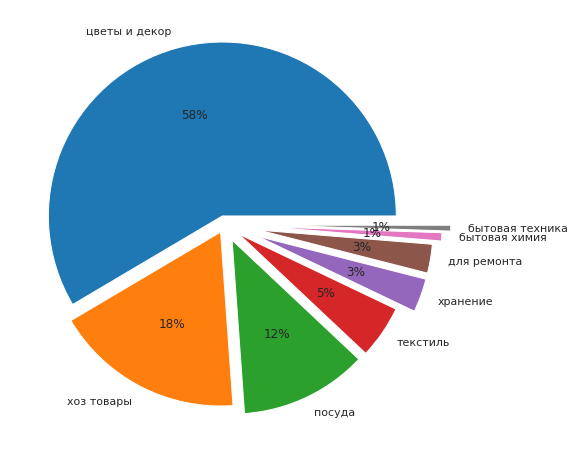

In [14]:
sns.set_style('darkgrid')
sns.set_context("notebook")
sns.set_palette("tab10")
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(types['type_product'], 
       labels=types['index'], 
       explode = (0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0.25, 0.3),
       autopct='%1.0f%%')

plt.show()

разбив на категории, замечаю что записей с продажами цветов и декора преобладают в нашем дата сете, в будущем проанализирую какая категория приности больше выручки, у кого какой средний чек и сезоность

а пока добавлю месяц и неделю покупки

In [15]:
df['week'] = df['date'].values.astype('datetime64[W]')
df['month'] = df['date'].values.astype('datetime64[M]')
df['month'].value_counts().sort_index(ascending=True) 

2018-10-01    484
2018-11-01    428
2018-12-01    317
2019-01-01    186
2019-02-01    363
2019-03-01    415
2019-04-01    677
2019-05-01    734
2019-06-01    295
2019-07-01    312
2019-08-01    202
2019-09-01    221
2019-10-01    219
Name: month, dtype: int64

In [16]:
df.to_csv('qqq.csv')

Теперь у нас есть месяц и неделя покупки они помогут на этапе анализа данных, на данном этапе я вижу что у нас данные с октября 2018 по октябрь 2019, и большое всего записей приходится на весенние месяцы, в будущем проанализирую подробнее

Мне осталось проверить данные на аномалии, начну с цен и количества конкретный позиций в заказе

In [17]:
df.describe()

,order_id,quantity,price
count,4853.000000,4853.000000,4853.000000
mean,48276.524006,2.832887,515.912425
std,27331.718140,17.639302,945.932617
min,12624.000000,1.000000,9.000000
25%,14774.000000,1.000000,90.000000
50%,68860.000000,1.000000,150.000000
75%,70834.000000,1.000000,502.000000
max,73164.000000,1000.000000,14917.000000


Вижу выбросы и что в столбце с кол-вом числятся значения больше одного, исходя из этого проверю какую цену указывают в столбце PRICE, за шт или тотал, сгрупирую данные для проверки

In [18]:
df.groupby(['product']).agg({'price': 'unique','quantity':'unique'}).reset_index().sort_values('product', ascending = False)

,product,price,quantity
2340,"ёрш унитазный с подставкой wc ""стандарт"", муль...",[67.0],[1]
2339,"ёрш унитазный с подставкой wc ""люкс"", мультипл...",[56.0],"[1, 2]"
2338,"ёрш унитазный с деревянной ручкой , ваир 1712012","[56.0, 59.0, 51.0]","[15, 3, 1, 10, 20, 23, 30]"
2337,"ёрш унитазный пластмассовый, ваир 1712002",[44.0],[1]
2336,ёрш радиаторный без ручки 1807007,[60.0],[2]
...,...,...,...
4,агератум рассада однолетних цветов в кассете п...,[210.0],[2]
3,автоматическая щетка leifheit для мытья окон с...,[7229.0],[1]
2,tepмокружка avex recharge 500 мл голубой avex0681,"[2324.0, 1874.0]",[1]
1,tepмокружка avex freeflow 700 мл сталь avex0776,[2399.0],[1]


Цены указаны за шт, в получившийся таблице это видно, в особенности с ершиками)), добавлю столбец с суммами цен

In [19]:
df['revenue'] = df['price'] * df['quantity']

столбец добавлю, теперь посмотрю ранее увиденные выбросы на скатерплотах

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


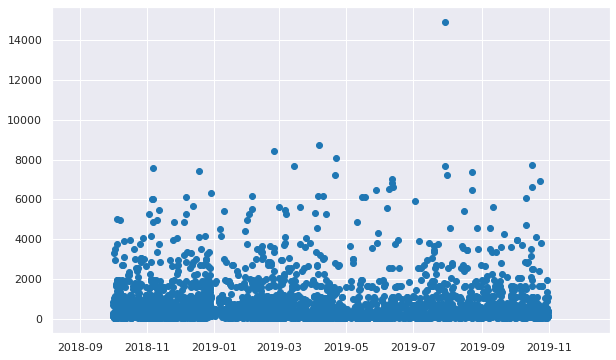

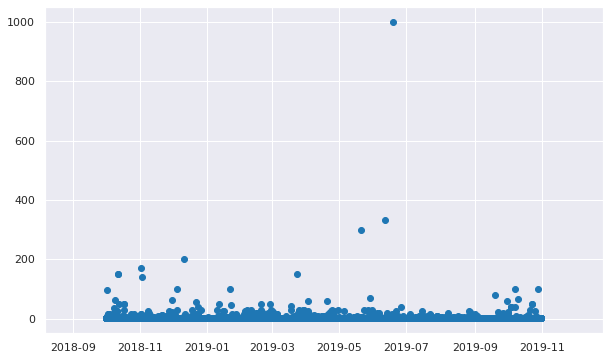

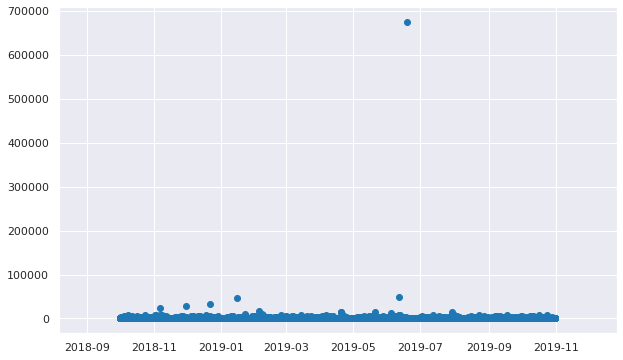

In [20]:
def scatter(a,b):
    fig, ax = plt.subplots()
    ax.scatter(x = b, y = a)
    fig.set_figwidth(10)    
    fig.set_figheight(6)
    plt.show()

       
scatter(df['price'], df['date'])
scatter(df['quantity'], df['date'])
scatter(df['revenue'], df['date']) 

На графиках четко видно выбросы, при этом на каждом из графиков видно четко по одному сильному выбросу, проверю одна и та же это строка или нет, отсортирую по ценнам 

In [21]:
df.sort_values('revenue', ascending = False).head(10)

,date,customer_id,order_id,product,quantity,price,type_product,week,month,revenue
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,хоз товары,2019-06-13,2019-06-01,675000.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,хранение,2019-06-06,2019-06-01,49432.0
1518,2019-01-15 13:00:00,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,простынь вафельная 200х180 см wellness rw180-0...,27,1755.0,текстиль,2019-01-10,2019-01-01,47385.0
1299,2018-12-21 16:00:00,6987e6d6-a63a-4ce2-a2d0-f424092d235e,69504,тележка багажная delta тбр-22 синий грузоподъе...,57,574.0,посуда,2018-12-20,2018-12-01,32718.0
1023,2018-11-29 17:00:00,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,набор ножей attribute chef 5 предметов akf522,64,457.0,хоз товары,2018-11-29,2018-11-01,29248.0
661,2018-11-06 12:00:00,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"урна уличная ""гео"", hobbyka/хоббика, 59*37,5см...",5,4874.0,хоз товары,2018-11-01,2018-11-01,24370.0
1675,2019-02-04 06:00:00,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,мусорный контейнер hailo bigbin swing 45 0845-...,3,5512.0,хранение,2019-01-31,2019-02-01,16536.0
2971,2019-04-19 19:00:00,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,одеяло wellness t142 белое темостеганое 140х20...,10,1568.0,хранение,2019-04-18,2019-04-01,15680.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0,цветы и декор,2019-05-16,2019-05-01,15300.0
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917.0,хоз товары,2019-07-25,2019-07-01,14917.0


вижу что выбросы по ценнам позиций это покупка одного из клиентов 1000 вантузов, перед стат анализом стоит удалить его а сейчас оставлю

In [22]:
df.sort_values('quantity', ascending = False).head(10)

,date,customer_id,order_id,product,quantity,price,type_product,week,month,revenue
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,хоз товары,2019-06-13,2019-06-01,675000.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,хранение,2019-06-06,2019-06-01,49432.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,муляж яблоко 9 см красное,300,51.0,цветы и декор,2019-05-16,2019-05-01,15300.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"ручка-скоба рс-100 белая *трибатрон*, 1108035",200,29.0,для ремонта,2018-12-06,2018-12-01,5800.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,муляж яблоко 9 см красное,170,51.0,цветы и декор,2018-11-01,2018-11-01,8670.0
212,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,пружина дверная 240 мм оцинкованная (д-19 мм) ...,150,38.0,для ремонта,2018-10-11,2018-10-01,5700.0
211,2018-10-11 14:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"крепеж для пружины дверной, 1107055",150,19.0,для ремонта,2018-10-11,2018-10-01,2850.0
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,плечики пластмассовые размер 52 - 54 тула 1205158,150,20.0,хранение,2019-03-21,2019-03-01,3000.0
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,муляж яблоко 9 см красное,140,59.0,цветы и декор,2018-11-01,2018-11-01,8260.0
6707,2019-10-28 10:00:00,018fb729-3525-4314-8e4d-1982b1062f9f,73110,"шпингалет 80 мм белый с пружиной, 1102188",100,44.0,для ремонта,2019-10-24,2019-10-01,4400.0


имется похожие покупки других позиций но с меньшим кол-вом позиций за раз, теперь посмотрю что покупал еще любитель вантузов

In [23]:
df[df['customer_id'] == '312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6']

,date,customer_id,order_id,product,quantity,price,type_product,week,month,revenue
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,хоз товары,2019-06-13,2019-06-01,675000.0


клиент больше не покупал, возможно он и правда купил только 1000 вантузов и больше не возвращался к нам, а может следующие покупки делал под другим id, посмотрю все ли вантузы пользуются таким спросом

In [24]:
df[df['product'].str.match('вантуз')]

,date,customer_id,order_id,product,quantity,price,type_product,week,month,revenue
1310,2018-12-22 23:00:00,709df21c-c9f3-4622-b830-4201cff05d1e,69516,вантуз черный с пластиковой ручкой малый д-100...,1,52.0,хоз товары,2018-12-20,2018-12-01,52.0
1916,2019-02-20 10:00:00,4a7fe822-c617-460a-a477-33be987babbf,70362,"вантуз черный с длинной ручкой (d-110 мм, l-38...",1,149.0,хоз товары,2019-02-14,2019-02-01,149.0
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,хоз товары,2019-06-13,2019-06-01,675000.0


Нет, за год только однажды купили больше одного вантуза, решаю что от этой записи нужно избавится но перед этим сгрупирую данные по клиентам и посмотрю как много они покупают

In [25]:
display(
    df.groupby('customer_id')
    .agg({'order_id':'nunique','revenue':'sum', 'quantity': 'sum'})
    .sort_values('quantity', ascending = False)
    .reset_index()
    .head(15)
)

,customer_id,order_id,revenue,quantity
0,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,1,675000.0,1000
1,146cd9bf-a95c-4afb-915b-5f6684b17444,1,49432.0,334
2,c971fb21-d54c-4134-938f-16b62ee86d3b,126,159508.0,334
3,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35,57278.0,309
4,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,1,15300.0,300
5,cd09ea73-d9ce-48c3-b4c5-018113735e80,1,8550.0,300
6,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,1,5800.0,200
7,aa42dc38-780f-4b50-9a65-83b6fa64e766,1,8670.0,170
8,685d3d84-aebb-485b-8e59-344b3df8b3d3,1,3000.0,150
9,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,1,8260.0,140


Теперь точно подтверждаю, любитель вантузов такой один, при это м есть похожие заказы

Данные готовы к дальнейшему анализу, все столбцы приведены к нужному формату, пропусков, дубликатов и аномалий нет.
В датасет добавлены столбцы с месяцем покупки и категорией товара.

# Иследовательский анализ данных

Для начала гляну какое количество в датасете уникальных заказов и покупателей

In [27]:
print('Количество уникальных заказов в датасете {}'.format(len(df['order_id'].unique())))
print('Количество уникальных клиентов в датасете {}'.format(len(df['customer_id'].unique())))

Количество уникальных заказов в датасете 2784
Количество уникальных клиентов в датасете 2451


За 13 месяцев в нашем магазине купили 2451 клиентов с общим числом заказов 2784, сгрупирую данные и посмотрю средние показатели по сумме заказа, кол-ву товара и заказов:

In [28]:
customers = df.groupby('customer_id').agg({'revenue':'sum', 'quantity':'sum', 'order_id':'nunique'})
customers.describe()

,revenue,quantity,order_id
count,2451.000000,2451.000000,2451.000000
mean,1685.397389,5.609139,1.149327
std,14255.696991,27.026756,2.655249
min,14.000000,1.000000,1.000000
25%,299.000000,1.000000,1.000000
50%,708.000000,1.000000,1.000000
75%,1574.000000,3.000000,1.000000
max,675000.000000,1000.000000,126.000000


Вижу что в среднем клиенты за 13 месяцев в нашем магазине покупают больше одного раза, на сумму 1685 руб и количеством товара в корзине чуть больше 5 шт.

посмотрю сколько равен средняя стоимоть одного заказа

In [29]:
df.groupby('order_id').agg({'revenue':'sum'}).mean()

revenue    1483.80352
dtype: float64

сумма среднего заказа равна 1483 руб

Гляну как распределяются количество заказоного товара, выручка и кол-во заказов в течении 13 месяцев

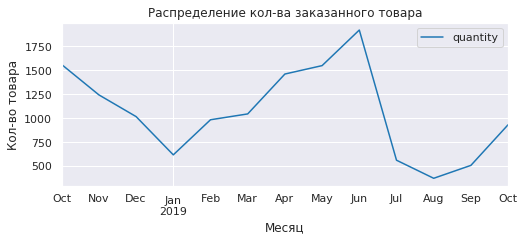

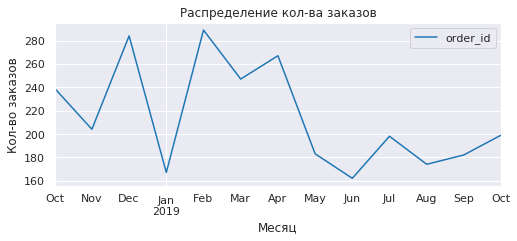

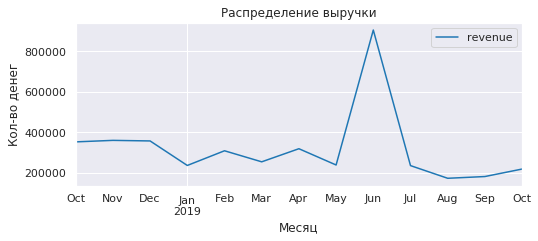

In [30]:
def plot_bar (sign, function):
    data = df.groupby('month').agg({sign:function}).reset_index()
    data.plot(x = 'month', y = sign, figsize = (8, 3))


plot_bar('quantity','sum')
plt.title('Распределение кол-ва заказанного товара')
plt.xlabel('Месяц')
plt.ylabel('Кол-во товара')
plt.show()

plot_bar('order_id','nunique')
plt.title('Распределение кол-ва заказов')
plt.xlabel('Месяц')
plt.ylabel('Кол-во заказов')
plt.show()

plot_bar('revenue','sum')
plt.title('Распределение выручки')
plt.xlabel('Месяц')
plt.ylabel('Кол-во денег')
plt.show()

Изучив 3 графика могу сделать некоторые предположения 

- за последние 5 месяц упали количество заказов, но в октябре замечаею рост
- имеется выброс в июне
- замечаю что в весенние месяца начинается увеличиваться кол-во позиций которые покупают клиенты, возможно это связано с началом дачного сезона и все начинают покупать рассаду и цветы
- отрицательная динамика выручки

посмотрю на категории товаров в размере выручки в долях от общей выручки


,type_product,revenue
0,хоз товары,1712252.0
1,посуда,862665.0
2,цветы и декор,702497.0
3,текстиль,381237.0
4,хранение,261368.0
5,для ремонта,170574.0
6,бытовая техника,23183.0
7,бытовая химия,17133.0


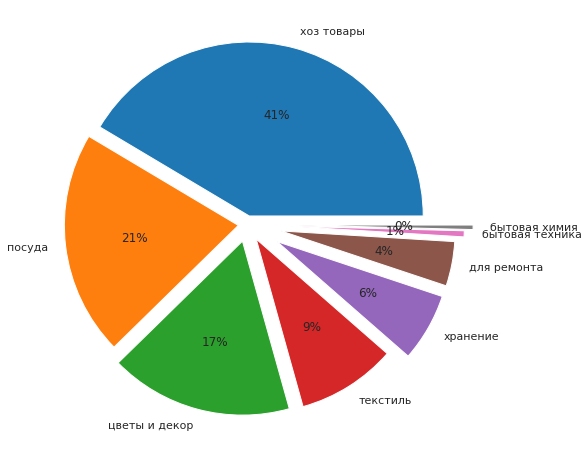

In [31]:
money_types = df.groupby('type_product').agg({'revenue':'sum'}).sort_values('revenue',ascending =False).reset_index()
display(money_types)

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(money_types['revenue'], 
       labels=money_types['type_product'], 
       explode = (0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0.25, 0.3),
       autopct='%1.0f%%')

plt.show()

Вижу что у нас есть 3 основных категории которые приносят деньги: "посуда", "хоз.товары" и "цветы и декор"

что бы понять как распределяется выручка по категориям построю линейную диаграмму

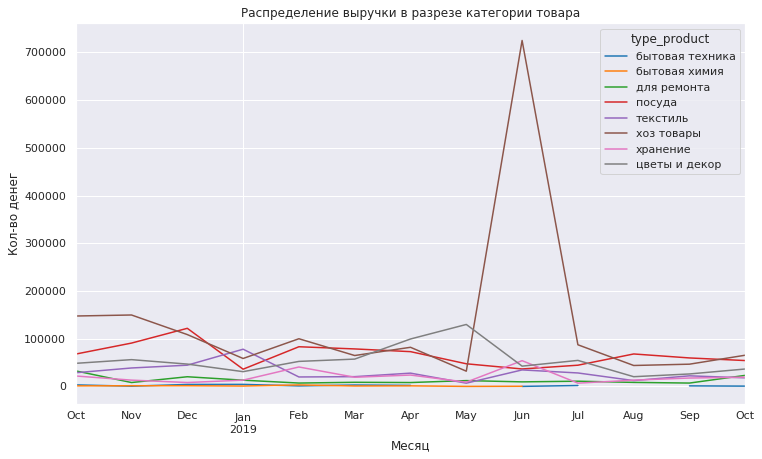

In [32]:
pivot_df = df.pivot_table(index = 'month', columns ='type_product', values = 'revenue', aggfunc ='sum')

pivot_df.plot(figsize = (12, 7))
plt.title('Распределение выручки в разрезе категории товара')
plt.xlabel('Месяц')
plt.ylabel('Кол-во денег')
plt.show()

Данный график плохо читается, но из него можно сделать выводы:
 - снова замечаю выброс с 1000 вантузами
 - сезоность имеется у категории "цветы и декор", начиная с января по июль начинается рост выручки на растения и рассаду, что логично все начинают заниматься садами и дачами.
 - выручка по трем значемым катеригориям "посуда", "хоз.товары" и "текстиль" падают с конца 2018 года, и это и влияет на снижение выручки по всех компании.
 - категории "Бытовая техника" и "бытовая химия" показывают очень низкие показатели продаж.
 
 
теперь гляну на уникальных пользователесь в течении разных временных промежутков, но для этого добаслю в данные столбец с днем покупки

In [33]:
df['day'] = df['date'].values.astype('datetime64[D]')#добавил дату покупки

dau = df.groupby('day').agg({'customer_id':'nunique'})
wau = df.groupby('week').agg({'customer_id':'nunique'})
mau = df.groupby('month').agg({'customer_id':'nunique'})

print('DAU — количество уникальных пользователей в день:', int(dau.mean()))
print('WAU — количество уникальных пользователей в неделю:', int(wau.mean()))    
print('MAU — количество уникальных пользователей в месяц', int(mau.mean()))

DAU — количество уникальных пользователей в день: 6
WAU — количество уникальных пользователей в неделю: 44
MAU — количество уникальных пользователей в месяц 192


Посмотрю как они распределяются в течении времени

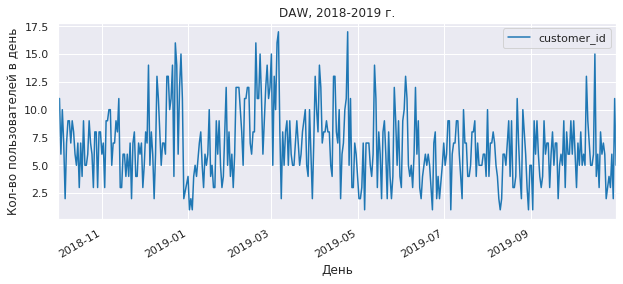

In [34]:
def chart (data, column_y, bottom_t, left_t, name_t):
    data.plot(y = column_y, style='-', grid=True, figsize=(10, 4))
    plt.xlabel(bottom_t)
    plt.ylabel(left_t)
    plt.title(name_t)
    plt.show()

chart (dau, 
       'customer_id',
       'День', 
       'Кол-во пользователей в день', 
       'DAW, 2018-2019 г.')

На графике четко заметно всплески активности покупателей, выделю три основных всплеска, перед новым годом, перед началом весны, и в конце весны. Предпологаю что перед новым годом люди бегут запасаться подарками или товарами для дома, что бы с пользой провести время в праздники, а весенние всплески предпологаю что это люди начинают заниматься стройкой и садом.

Посмотрю на недельные рапределения

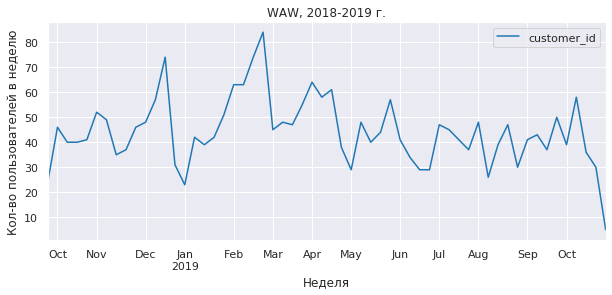

In [35]:
chart (wau, 
       'customer_id', 
       'Неделя', 
       'Кол-во пользователей в неделю', 
       'WAW, 2018-2019 г.')

Распределение заказов по неделям подтверждает ранее сделанные выводы, но на этом графике мартовский сплес видет отчетливо хорошо

Гляну как рапределялись заказы по дням недели, часу и месяцу

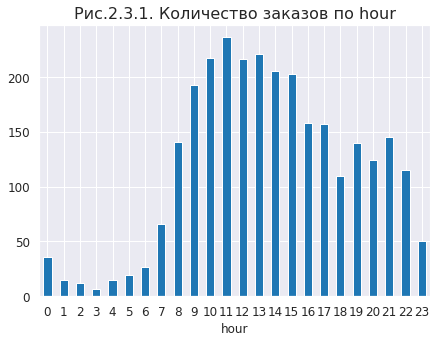

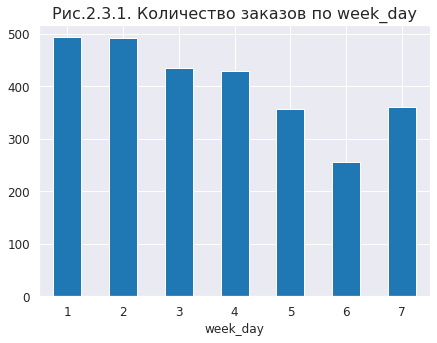

In [36]:
# добавлю столюцы с нужными данными
df['hour'] = df['date'].dt.hour
df['week_day'] = (df['date'].dt.dayofweek) +1

for columns in ['hour', 'week_day']:
    df.pivot_table(index=columns, values='order_id', aggfunc='nunique', fill_value=0)\
    .plot(kind='bar', figsize=(7,5), grid=True, y=['order_id'], fontsize=12, legend=False)
    plt.title('Рис.2.3.1. Количество заказов по ' + columns, fontsize=16)
    plt.xticks(rotation=0)
    plt.show()

По данным кол-ва заказов в разрезе дня недели и часа можно предположить, что большая часть людей заказывает у нас товары в рабочие дни и в рабочее время, можно в эти часы и дни увеличивать рекламу нашего магазина.

ВЫВОД:
* в июне в магазине купил клиент 1000 вантузов
* Количество уникальных заказов в датасете 2784
* Количество уникальных клиентов в датасете 2451
* Клиенты покупают больше одного раза, на сумму 1685 руб и количеством товара в корзине более 5 шт.
* Сумма среднего заказа равна 1483 руб
* за последние 5 месяц падение количество заказов, с октября начинается рост
* имеется сезоность как месячная так и дневная и часовая
* отрицательная тренд динамики выручки
* 3 основных категории приносят выручку "посуда", "хоз.товары" и "цветы и декор"
* в разрезе категорий тоже имеется сезонность

# Статистический анализ данных

Перед проведением статистического анализа я удалю выбросы, для этого посмотрю на заказы в разрезе revenue и quantity, так как при анализе этих паказателей наиболее заметны были выбросы,а так же на цены товаров, использовать буду процентили

In [37]:
df_values = df.groupby('order_id').agg({'quantity':'sum', 'revenue':'sum'}).reset_index()# посчитаю выручку и кол-во позиций в разрезе заказа

def per_1_99(data):
    per = np.percentile(data, [1, 99])
    print("1-й процентиль равен {} , 99-й процентиль равен {}"
      .format(per[0].round(2),per[1].round(2)))
# тут не знаю как в ставить в функцию принт название столбца по которым я получаю процентиль, буду рад подсказке

per_1_99(df_values['quantity'])    
per_1_99(df_values['revenue'])   
per_1_99(df['price'])  

1-й процентиль равен 1.0 , 99-й процентиль равен 51.68
1-й процентиль равен 44.0 , 99-й процентиль равен 8263.06
1-й процентиль равен 15.0 , 99-й процентиль равен 4952.84


Теперь получу номера заказов с выбросами по выручке и кол-ву товаров и удалю эти заказы, а так же удалю торвары с выбросами по цене

In [38]:
right_orders = df_values.query('51.68 >= quantity >= 1 and 8263 >= revenue >= 44')['order_id']
df= df.query('order_id in @right_orders')
# сначала удалил выбросы по заказам

df = df.query('4952.84 >= price >= 15')
# потом удалил выбросы по ценам
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4612 entries, 0 to 6735
Data columns (total 13 columns):
date            4612 non-null datetime64[ns]
customer_id     4612 non-null object
order_id        4612 non-null int64
product         4612 non-null object
quantity        4612 non-null int64
price           4612 non-null float64
type_product    4612 non-null object
week            4612 non-null datetime64[ns]
month           4612 non-null datetime64[ns]
revenue         4612 non-null float64
day             4612 non-null datetime64[ns]
hour            4612 non-null int64
week_day        4612 non-null int64
dtypes: datetime64[ns](4), float64(2), int64(4), object(3)
memory usage: 504.4+ KB


Было 4853 строк, стало 4612, удалил примерно 240 строк с выбрасами

Тепрь гляну коррелируют ли количество заказов, сумма выручки, цена и кол-во позиций в заказе в разрезе недели

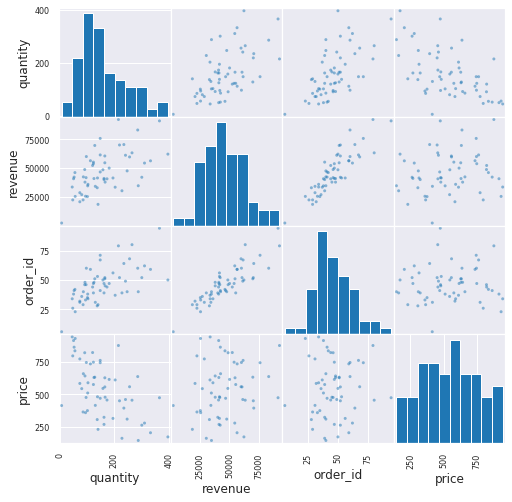

          quantity   revenue  order_id     price
quantity  1.000000  0.574578  0.621358 -0.568647
revenue   0.574578  1.000000  0.877393  0.159237
order_id  0.621358  0.877393  1.000000  0.034258
price    -0.568647  0.159237  0.034258  1.000000


In [39]:
df_corr = df.groupby('week').agg({'quantity':'sum', 'revenue':'sum', 'order_id':'nunique', 'price': 'mean'})
pd.plotting.scatter_matrix(df_corr, figsize=(8, 8)) 
plt.show()
print(df_corr.corr())

Сильная положительная кареляция имеется между показателями выручка, кол-во заказов и кол-во позиций в заказе, поэтому что бы увеличить выручку нужно стремится увеличивать количество заказов и количество позиций в заказе.

Интереснее ситуация с ценой товара, чем цена меньше тем количество позиций больше в заказе, либо, с выручкой и кол-вом заказов цена товар почти не корелирует.

А теперь проведу кластеризацию продуктов, для этого подготовлю отдельную таблицу

In [40]:
#добавлю dummy-переменные по категориям товара
df = df.join(pd.get_dummies(df.type_product))


product_claster = (
    df.groupby('product')
    .agg({
        'quantity':'sum', 
        'price':'mean',
        'order_id':'nunique',
        'бытовая техника':'max',
        'бытовая химия':'max',
        'для ремонта':'max',
        'посуда':'max',
        'текстиль':'max',
        'хоз товары':'max',
        'хранение':'max',
        'цветы и декор':'max',
        }).reset_index())
product_claster.describe()

,quantity,price,order_id,бытовая техника,бытовая химия,для ремонта,посуда,текстиль,хоз товары,хранение,цветы и декор
count,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000,2197.000000
mean,4.152025,545.137131,2.085116,0.010924,0.011834,0.040965,0.115157,0.076923,0.216204,0.046882,0.481111
std,9.024436,804.231739,3.404907,0.103969,0.108165,0.198254,0.319284,0.266530,0.411749,0.211434,0.499757
min,1.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,97.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,188.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,674.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,148.000000,4949.000000,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Теперь построю кластеризацию

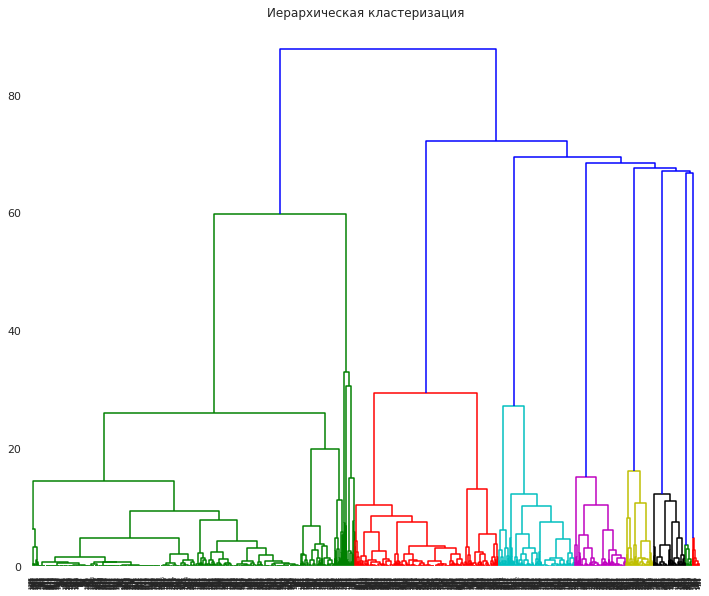

In [43]:
#разделю данные на признаки (матрица X) и целевую переменную (y)
X = product_claster.drop('product', axis=1)
y = product_claster['product']

# стандартизирую данные 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Построю матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисую дендрограмму.
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(12, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

По полученной дендрограмме выделяю 2 кластера.

Обучу модель кластеризации на основании алгоритма K-Means и спрогнозируйте кластеры товаров, количество кластеров возьму 2.

In [46]:
# задаю модель k_means с количеством кластеров 2
km = KMeans(n_clusters = 2, random_state=0)
# спрогнозирую кластеры для наблюдений 
labels = km.fit_predict(X_sc)

# сохраню метки кластера в поле новой таблице
product_claster['cluster'] = labels

# посчитаю метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels) ))

Silhouette_score: 0.27


Значение метрики силуета оказалось довольно низким.

Посмотрю на средние значения признаков кластеров. 

In [47]:
product_claster.groupby('cluster').mean().T

cluster,0,1
quantity,3.456842,4.343786
price,862.412393,457.619274
order_id,1.696842,2.192218
бытовая техника,0.000000,0.013937
бытовая химия,0.000000,0.015099
для ремонта,0.000000,0.052265
посуда,0.000000,0.146922
текстиль,0.000000,0.098142
хоз товары,1.000000,0.000000
хранение,0.000000,0.059814


# После кластеризации выделяю следующие кластеры товаров

**Кластер 0:**

  *в основном  хоз товары(100 %), количество заказов (меньше 2-х), средняя цена товара в 2 раза выше товар из второго кластра, предположу что это основной сегмент товара*

**Кластер 1:**
 
  *В этом кластере остальные позиции из нашего магазина, но в основном это цветы и декор(61 %), но так же есть категории посуда (15%) тексить (10%), хранения (6%), товаров для ремонта(5%), бытовой химии(1%) и бытовой техники(1%), средняя стоимость товара 457 рублей, кол-во проданного товара(4 шт), предпологаю что это дополнительный сегент*


# Проверка статистических гипотез

Начну с нахождения выручки и среднего чека

In [48]:
product_claster['revenue'] = product_claster['quantity'] * product_claster['price']
product_claster['avg_check'] = product_claster['revenue'] / product_claster['order_id']


display(product_claster.groupby(['cluster']).mean().T)

cluster,0,1
quantity,3.456842,4.343786
price,862.412393,457.619274
order_id,1.696842,2.192218
бытовая техника,0.000000,0.013937
бытовая химия,0.000000,0.015099
для ремонта,0.000000,0.052265
посуда,0.000000,0.146922
текстиль,0.000000,0.098142
хоз товары,1.000000,0.000000
хранение,0.000000,0.059814


Получив эти данные о выручке и среднем чеке мои предположения укрепились  что 1-й сегмент основной а 2-й дополнительный, но укреплю свои доводы и проведу статистическое сравнения двух сегментов.

Сначала посчитаю статистическую значимость различий в среднем чеке заказа между сегментами товара.

Сформулирую нулевую и альтернативную гипотезы:

- Нулевая гипотеза H₀: Нет статистически значимых различий в среднем чеке между сегментами товра.
- Альтернативная гипотеза H₁: Есть статистически значимое различие в среднем чеке между между сегментами товра.

Сгенерирую 2 выборки по кластерам

In [49]:
first_cluster_1 = product_claster[product_claster['cluster']==0]['avg_check']
second_cluster_1 = product_claster[product_claster['cluster']==1]['avg_check']

Выполню проверу гипотезы

In [50]:
alpha = 0.05 
results = stats.mannwhitneyu(first_cluster_1, second_cluster_1) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.419131773084417e-44
Отвергаем нулевую гипотезу


P-value значительно меньше 0,05. по этой причине отвергаю нулевую гипотезу что значит что, есть статистически значимое различие в среднем чеке между сегментами товаров.

Посчитаю статистическую значимость различий в среднем объёме продаж между сегментами товаров.

Гипотеза №2.

Сформулируем нулевую и альтернативную гипотезы:

- Нулевая гипотеза H₀: Нет статистически значимых различий в среднем объёме продаж между сегментами товаров.
- Альтернативная гипотеза H₁: Есть статистически значимое различие в среднем объёме продаж между сегментами товаров.

In [51]:
first_cluster_2 = product_claster[product_claster['cluster']==0]['revenue']
second_cluster_2 = product_claster[product_claster['cluster']==1]['revenue']

alpha = 0.05 
results = stats.mannwhitneyu(first_cluster_1, second_cluster_1) 

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.419131773084417e-44
Отвергаем нулевую гипотезу


P-value значительно меньше 0,05. по этой причине отвергаю нулевую гипотезу что значит что есть статистически значимое различие в среднем обьеме продаж между сегментами товаров.


ВЫВОД:
Подстверждаю свои предположения что кластер 1 основной, а кластер 2 дополнительный.

# ВЫВОД

Имеются данные с октября с 2018-10-01 по 2019-10-31, в данных обнаружены дубликаты записей 1884 шт данные были удалены.
В датасет добавлены категория товара месяц, неделя, день и час покупки.
Был найден заказ с анамальным заказов в 1000 ванузов, заказ был удален.

На этапе иследования данных была выявлена следующая информация:

- Количество уникальных заказов в датасете 2784
- Количество уникальных клиентов в датасете 2451
- В среднем клиенты покупают больше одного раза, на сумму 1685 руб и количеством товара в корзине 5 шт.
- Сумма среднего заказа равна 1483 руб
- За последние 5 месяц замечано падение количество заказов, с октября 2019 г начинается рост
- Имеется сезоность товара как месячная так и дневная и часовая
    - в разрезе часа клиенты в основном покупают днем в рабочее время
    - в разрезе дня недели, клиенты чаще покупаю т в начале недели и наблюдается постепенный спад к концу недели
    - в разрезе месяца сезоность зависит от категории товара, цветы и декор начинают покупать активно весной, и посуда и хоз.товары закупают переддлинными выходными
- Замечен отрицательный тренд динамики выручки
- 3 категории "посуда", "хоз.товары" и "цветы и декор", приносят большую часть выручки 
- замечана кореляция между стоимсотью заказа количество позиций в заказе и стоимотью товара, это и так логично))


На этапе статистичекого иследования выявлены 2 класера:

Кластер 0(основной):

в основном хоз товары(100 %), количество заказов (меньше 2-х), средняя цена товара в 2 раза выше товар из второго кластра, средняя выручка одного заказа 1700 руб.

Кластер 1(дополнительный):

В этом кластере остальные позиции из нашего магазина, но в основном это цветы и декор(61 %), но так же есть категории посуда (15%) тексить (10%), хранения (6%), товаров для ремонта(5%), бытовой химии(1%) и бытовой техники(1%), средняя стоимость товара 457 рублей, кол-во проданного товара(4 шт).


Проведены 2 сравнения на статистически значимое различие выручки и среднего чека между 2-мя категориями, по результатам теста я оклонил нудевую гипотезу в обоих случаях что значит что статистически значимые различия имеются.


Рекомендации:
- проанализировать инструменты привлечения клиентов, почему паают продажи
- разработать систему мотивации клиента брать больше позиций
- увеличить кол-во рекламы нашего магазина  именно в рабочие часы.
- разработать стратегию рекламы на основании сезоности товарных групп, например больше рекламировать товары растения и декор весной
- сосредоточится на размещении рекламы в первую очередь товара из основного кластера, так как он приносит больше выручки.
- провести иследования рентабельности продаж категорий товаров бытовая химия и бытовая техника.


# Доп материалы

Ссылка на дашборд: https://public.tableau.com/app/profile/nikolai3235/viz/E-commerce_16452912992390/Dashboard1?publish=yes

Ссылка на презентацию: https://disk.yandex.ru/i/k45J0m2BdMuagA
